In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pandas_profiling import ProfileReport

In [22]:
%cd ..
%cd data/raw

C:\Users\SiddharthaMisra\Documents\Springboard\ML_Contributions\data
[WinError 3] The system cannot find the path specified: 'data/raw'
C:\Users\SiddharthaMisra\Documents\Springboard\ML_Contributions\data


In [23]:
df = pd.read_csv('1.1 Processed Data.csv')
df = df.drop(['owner_no.1', 'order_dt.1'], axis=1)

FileNotFoundError: [Errno 2] No such file or directory: '1.1 Processed Data.csv'

In [ ]:
%cd ..\..

In [24]:
%cd reports

[WinError 2] The system cannot find the file specified: 'reports'
C:\Users\SiddharthaMisra\Documents\Springboard\ML_Contributions\data


In [ ]:
report1 = ProfileReport(df).to_file("Raw Data Profile - Pandas Profiling.html")

In [25]:
%cd figures

[WinError 2] The system cannot find the file specified: 'figures'
C:\Users\SiddharthaMisra\Documents\Springboard\ML_Contributions\data


In [ ]:
sns.pairplot(df, height=2, aspect=1)
plt.savefig("Raw Data - Seaborn Pairplot.png")
plt.show()

In [26]:
df.dtypes

owner_no                                       int64
order_dt                              datetime64[ns]
tot_ticket_paid_amt                          float64
tot_contribution_paid_amt                    float64
first_order_dt                        datetime64[ns]
first_cont_dt                         datetime64[ns]
geo_area_desc                                  int64
Prelim Capacity                                int64
ltv_tkt_value                                float64
Lifetime Giving                              float64
prospect_board                                 int64
days_to_donation                               int64
first_cont_order                               int64
first_cont_after                               int64
rolling_tkt_sum                              float64
channel_desc_3rd Party                         int64
channel_desc_At the Performance                int64
channel_desc_Chat                              int64
channel_desc_Default Channel                  

In [27]:
#Create datetime data types
df.order_dt=pd.to_datetime(df.order_dt, errors='coerce')
df.first_order_dt = pd.to_datetime(df.first_order_dt, errors='coerce')
df.first_cont_dt = pd.to_datetime(df.first_cont_dt, errors='coerce')

In [28]:
num_cols = [
    'tot_ticket_paid_amt',
    'tot_contribution_paid_amt',
    'ltv_tkt_value',
    'Lifetime Giving',
    'days_to_donation',
    'rolling_tkt_sum'
]

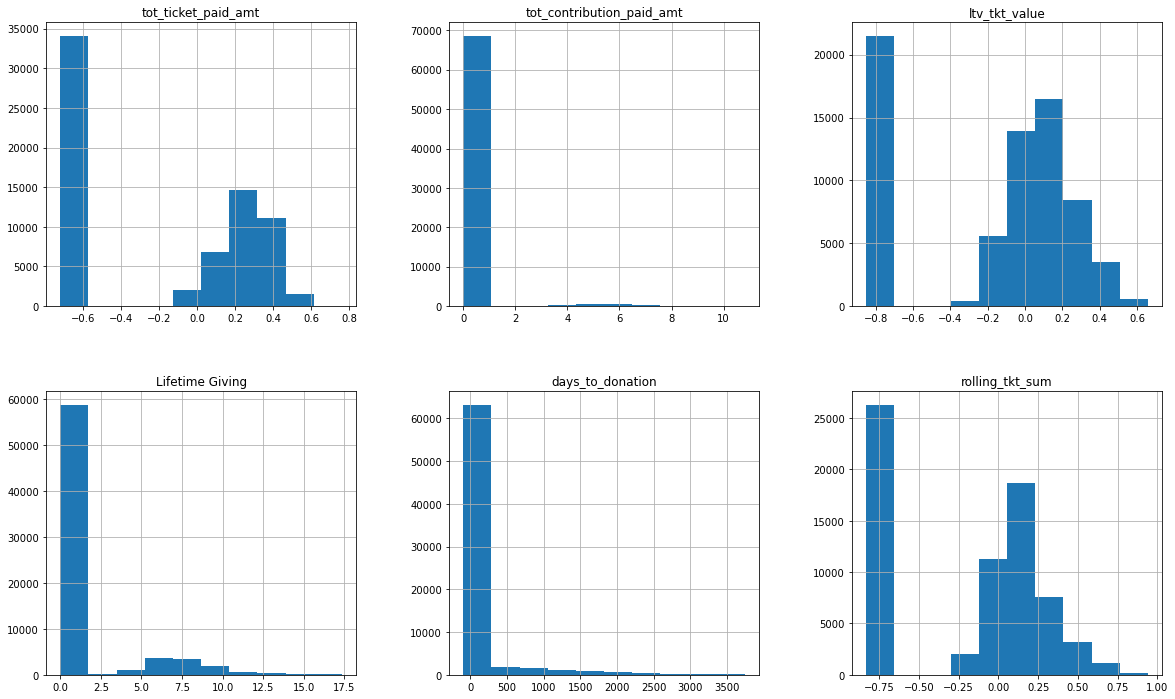

In [29]:
fig = df[num_cols].hist(layout = (2,3), figsize = (20,12))
plt.savefig('Histograms of Numerical Data.png')
plt.show()

In [30]:
data = []
for col in num_cols:
    values = [
        col, 
        round(df[col].max(),2),
        round(df[col].quantile(.99),2),
        round(df[col].quantile(.98),2),
        round(df[col].quantile(.97),2),
        round(df[col].quantile(.96),2)
    ]
    data.append(values)
quantile_df = pd.DataFrame(data, columns = ['cat', 'max', '99','98','97','96'])
quantile_df

,cat,max,99,98,97,96
0,tot_ticket_paid_amt,0.76,0.52,0.47,0.45,0.43
1,tot_contribution_paid_amt,10.82,5.99,4.61,0.00,0.00
2,ltv_tkt_value,0.66,0.49,0.45,0.42,0.40
3,Lifetime Giving,17.35,11.76,10.04,9.32,8.78
4,days_to_donation,3747.00,2503.00,1985.00,1635.00,1369.00
5,rolling_tkt_sum,0.94,0.65,0.58,0.53,0.49


In [32]:
new = df.days_to_donation[df.days_to_donation >= 0]
new.max(), new.quantile(.99), new.quantile(.98), new.quantile(.97)

(3747, 3608.0, 3155.0, 2924.0)

In [11]:
num_cols.remove('days_to_donation')
for col in num_cols:
    new_values = df[col].replace(0,0.1)
    df[col] = np.log(new_values)

In [13]:
new_df = df[df.prospect_board == 0]
data = []
for col in num_cols:
    values = [
        col, 
        new_df[col].max(),
        new_df[col].quantile(.99),
        new_df[col].quantile(.98),
        new_df[col].quantile(.97),
        new_df[col].quantile(.96)
    ]
    data.append(values)
quantile_df2 = pd.DataFrame(data, columns = ['cat', 'max', '99','98','97','96'])
quantile_df2

,cat,max,99,98,97,96
0,tot_ticket_paid_amt,8.364508,6.731018,6.440947,6.253829,6.165418
1,tot_contribution_paid_amt,8.517193,3.688879,2.302585,-2.302585,-2.302585
2,ltv_tkt_value,10.412441,9.051345,8.740960,8.499742,8.284757
3,Lifetime Giving,11.550726,8.004700,7.091742,6.551080,6.214608
4,rolling_tkt_sum,11.682373,9.332268,8.880035,8.433812,8.132119


### <center> Examining Collinearity of Independent Variables </center> ###

Here, I want to confirm whether the features that reference a customer's status as a donor prospect or Board member or their Lifetime Giving amounts are collinear with any of our target: making a donation on the first order, donating after a first order, or days until making a donation.

In [14]:
#Calculate VIF to eliminate collinearity
x1 = df[['first_cont_order', 'first_cont_after', 'days_to_donation', 'tot_contribution_paid_amt','prospect_board','Lifetime Giving']]
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = x1
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,1.101532,first_cont_order
1,5.438291,first_cont_after
2,2.415926,days_to_donation
3,3.037641,tot_contribution_paid_amt
4,1.165598,prospect_board
5,4.904971,Lifetime Giving


In [15]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
for col in num_cols:
    new_col = df[col].values.reshape(-1,1)
    df[col] = scaler.fit_transform(new_col)

In [16]:
df.head()

,owner_no,order_dt,tot_ticket_paid_amt,tot_contribution_paid_amt,first_order_dt,first_cont_dt,geo_area_desc,Prelim Capacity,ltv_tkt_value,Lifetime Giving,...,delivery_desc_Digital,delivery_desc_Do Not Print Tickets,delivery_desc_Mail,delivery_desc_Will Call,facility_desc_Academy of Music,facility_desc_Fundraiser,facility_desc_Independence Mall,facility_desc_Other,facility_desc_Perelman,facility_desc_Small venue
0,111,2015-10-07,0.262550,0.0,2015-10-07,1900-01-01,1,5,0.104660,0.0,...,0,0,0,1,1,0,0,0,0,0
1,111,2016-09-16,0.280947,0.0,2015-10-07,1900-01-01,1,5,0.104660,0.0,...,0,0,0,1,1,0,0,0,0,0
2,111,2018-09-21,0.170287,0.0,2015-10-07,1900-01-01,1,5,0.104660,0.0,...,0,0,0,1,1,0,0,0,0,0
3,258,2014-09-28,0.290096,0.0,2014-09-28,1900-01-01,5,6,0.014668,0.0,...,0,0,0,1,1,0,0,0,0,0
4,262,2014-10-02,0.110229,0.0,2014-10-02,1900-01-01,2,4,-0.058711,0.0,...,0,0,0,1,1,0,0,0,0,0


In [17]:
cd ..\..

C:\Users\SiddharthaMisra\Documents\Springboard\ML_Contributions


In [18]:
%cd data\processed

C:\Users\SiddharthaMisra\Documents\Springboard\ML_Contributions\data\processed


In [19]:
df.to_csv('2.0 Processed Data with Scaled and Log Transformations.csv')

In [ ]:
%cd ..\..
%cd reports

In [ ]:
report2 = ProfileReport(df).to_file("Processed Data Profile - Pandas Profiling.html")